In [104]:
import warnings
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from hmmlearn import hmm

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [286]:
### open, close, high, low data
### downloaded from 'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol=SPY&apikey=Y3H8BI0J9FPQPOAB'

### https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=SPY&outputsize=full&apikey=Y3H8BI0J9FPQPOAB
df = pd.read_csv('monthly_adjusted_SPY.csv',  parse_dates=['timestamp'])

df.rename({'timestamp': 'time'}, axis = 1, inplace= True)

df.drop(['adjusted close', 'dividend amount'], axis = 1, inplace= True)

dfhl = pd.read_csv('./daily_adjusted_SPY.csv', parse_dates=['timestamp'])

dfhl.rename({'timestamp':'time'}, axis = 1, inplace=True)

df_minutes = pd.read_csv('./algebros0530/dfhl.csv', parse_dates=['time'])

df_minutes

,time,open,volume,MACD,MACD_Hist,MACD_Signal,high,low
0,2023-05-19 15:59:00,418.96,2143843,0.1287,0.0285,0.1002,418.960,418.95
1,2023-05-19 15:58:00,418.95,1261060,0.1228,0.0298,0.0930,418.960,418.87
2,2023-05-19 15:57:00,418.87,1400980,0.1146,0.0290,0.0856,418.960,418.87
3,2023-05-19 15:56:00,418.91,661219,0.1105,0.0322,0.0784,418.960,418.87
4,2023-05-19 15:55:00,418.89,758281,0.0997,0.0294,0.0703,418.960,418.82
...,...,...,...,...,...,...,...,...
6235,2023-04-28 09:34:00,411.98,222984,0.1197,0.0466,0.0732,414.750,411.98
6236,2023-04-28 09:33:00,412.14,188445,0.1086,0.0471,0.0615,414.750,411.95
6237,2023-04-28 09:32:00,411.95,282485,0.0766,0.0269,0.0497,414.750,411.90
6238,2023-04-28 09:31:00,411.90,306992,0.0540,0.0109,0.0430,414.695,411.49


In [267]:
dfhl.drop(['adjusted_close', 'volume', 'dividend_amount', 'split_coefficient'], axis = 1, inplace= True)

dfhl

,time,open,high,low,close
0,2023-06-01,418.090000,422.920000,416.790000,421.820000
1,2023-05-31,418.280000,419.220000,416.220000,417.850000
2,2023-05-30,422.030000,422.580000,418.735000,420.180000
3,2023-05-26,415.330000,420.770000,415.250000,420.020000
4,2023-05-25,414.740000,416.160000,412.410100,414.650000
...,...,...,...,...,...
5929,1999-11-05,138.625000,139.109299,136.781204,137.875000
5930,1999-11-04,136.750000,137.359299,135.765594,136.531204
5931,1999-11-03,136.000000,136.375000,135.125000,135.500000
5932,1999-11-02,135.968704,137.250000,134.593704,134.593704


In [106]:
start_date, end_date = df['time'].iloc[-1], df['time'].iloc[0]

In [107]:
### macd data
### downloaded from 'https://www.alphavantage.co/query?function=MACD&symbol=SPY&interval=monthly&series_type=open&datatype=csv&apikey=Y3H8BI0J9FPQPOAB'

df_macd = pd.read_csv('technical_indicator_SPY.csv', parse_dates=['time'])

df_macd

,time,MACD,MACD_Hist,MACD_Signal
0,2023-05-31,8.8522,-3.6630,12.5152
1,2023-04-28,8.1436,-5.2874,13.4310
2,2023-03-31,7.7946,-6.9582,14.7528
3,2023-02-28,8.7592,-7.7331,16.4924
4,2023-01-31,8.8689,-9.5567,18.4256
...,...,...,...,...
244,2003-01-31,-8.0228,-0.1772,-7.8456
245,2002-12-31,-8.1162,-0.3150,-7.8013
246,2002-11-29,-8.5429,-0.8204,-7.7225
247,2002-10-31,-8.4739,-0.9564,-7.5174


In [108]:
df_merged = pd.merge(df, df_macd, how = 'inner', on = ['time'])

# df_merged.sort_values('time', ascending=True, inplace= True)

df_merged

,time,open,high,low,close,volume,MACD,MACD_Hist,MACD_Signal
0,2023-05-31,415.470,422.58,403.740,417.85,1776447412,8.8522,-3.6630,12.5152
1,2023-04-28,408.850,415.94,403.780,415.93,1392713656,8.1436,-5.2874,13.4310
2,2023-03-31,395.410,409.70,380.650,409.39,2516860295,7.7946,-6.9582,14.7528
3,2023-02-28,405.211,418.31,393.640,396.26,1603224252,8.7592,-7.7331,16.4924
4,2023-01-31,384.370,408.16,377.831,406.48,1575449950,8.8689,-9.5567,18.4256
...,...,...,...,...,...,...,...,...,...
244,2003-01-31,88.850,93.86,84.150,86.06,911319900,-8.0228,-0.1772,-7.8456
245,2002-12-31,95.470,96.05,87.110,88.23,728285900,-8.1162,-0.3150,-7.8013
246,2002-11-29,88.350,94.95,87.450,93.98,818243400,-8.5429,-0.8204,-7.7225
247,2002-10-31,82.430,91.29,77.070,88.52,1344248100,-8.4739,-0.9564,-7.5174


In [109]:
# df_percentage = df_merged.copy()

# df_percentage['open'] = df_merged['close'] - df_merged

In [110]:
gap = int(len(df_merged)*0.8)

X_train = df_merged.iloc[:gap]
X_test = df_merged.iloc[gap:]

X_train
# X_test

,time,open,high,low,close,volume,MACD,MACD_Hist,MACD_Signal
0,2023-05-31,415.470,422.58,403.740,417.85,1776447412,8.8522,-3.6630,12.5152
1,2023-04-28,408.850,415.94,403.780,415.93,1392713656,8.1436,-5.2874,13.4310
2,2023-03-31,395.410,409.70,380.650,409.39,2516860295,7.7946,-6.9582,14.7528
3,2023-02-28,405.211,418.31,393.640,396.26,1603224252,8.7592,-7.7331,16.4924
4,2023-01-31,384.370,408.16,377.831,406.48,1575449950,8.8689,-9.5567,18.4256
...,...,...,...,...,...,...,...,...,...
194,2007-03-30,139.340,143.81,136.750,142.00,2918304400,5.4658,0.6760,4.7897
195,2007-02-28,144.150,146.42,139.000,140.93,1494548900,5.5383,0.9176,4.6207
196,2007-01-31,142.250,144.13,140.250,143.75,1330329900,5.1938,0.8024,4.3913
197,2006-12-29,140.530,143.24,138.970,141.62,1212756800,4.8193,0.6286,4.1907


In [111]:
#dirichlet_params = np.array([1., 20., 20., 20.])
#dirichlet_params = np.random.randint(1,50,NUM_STATES)
labels = ['close','open','high','low', 'MACD', 'MACD_Hist', 'MACD_Signal']
likelihood_vect = np.empty([0,1])
aic_vect = np.empty([0,1])
bic_vect = np.empty([0,1])
hqc_vect = np.empty([0,1])
caic_vect = np.empty([0,1])

aic_vect

array([], shape=(0, 1), dtype=float64)

In [233]:
df

,time,open,high,low,close,volume
0,2023-05-31,415.4700,422.5800,403.7400,417.8500,1776447412
1,2023-04-28,408.8500,415.9400,403.7800,415.9300,1392713656
2,2023-03-31,395.4100,409.7000,380.6500,409.3900,2516860295
3,2023-02-28,405.2110,418.3100,393.6400,396.2600,1603224252
4,2023-01-31,384.3700,408.1600,377.8310,406.4800,1575449950
...,...,...,...,...,...,...
277,2000-04-28,150.1250,153.1093,133.5000,145.0937,229246200
278,2000-03-31,137.6250,155.7500,135.0312,150.3750,247594900
279,2000-02-29,139.7500,144.5625,132.7187,137.4375,186938300
280,2000-01-31,148.2500,148.2500,135.0000,139.5625,156770800


In [308]:
data_train = X_train.drop(['time'], axis = 1).to_numpy()
data_test = X_test.drop(['time'], axis = 1).to_numpy()

# data_whole = df.drop(['time', 'volume'], axis = 1).to_numpy()

# data_whole = dfhl.drop(['time', 'volume', 'MACD', 'MACD_Hist', 'MACD_Signal'], axis = 1).to_numpy()

data_whole = dfhl.drop(['time'], axis = 1).to_numpy()

data_whole = df_minutes[['open', 'high', 'low', 'MACD']].to_numpy()

data_whole



array([[4.18960e+02, 4.18960e+02, 4.18950e+02, 1.28700e-01],
       [4.18950e+02, 4.18960e+02, 4.18870e+02, 1.22800e-01],
       [4.18870e+02, 4.18960e+02, 4.18870e+02, 1.14600e-01],
       ...,
       [4.11950e+02, 4.14750e+02, 4.11900e+02, 7.66000e-02],
       [4.11900e+02, 4.14695e+02, 4.11490e+02, 5.40000e-02],
       [4.11490e+02, 4.14695e+02, 4.11490e+02, 2.94000e-02]])

In [309]:
NUM_TEST = 120
NUM_ITERS = 10000
K = 120

predicted_stock_data = np.empty([0,data_whole.shape[1]])

# print(data_whole)

for idx in reversed(range(NUM_TEST)):
        train_dataset = data_whole[idx + 1:,:]
        test_data = data_whole[idx,:]; 
        num_examples = train_dataset.shape[0]
        #model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', startprob_prior=dirichlet_params, transmat_prior=dirichlet_params, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')
        if idx == NUM_TEST-1:
            model = hmm.GaussianHMM(n_components=4, covariance_type='diag',  tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
        else:
            # return the model by using the HMM paramters from the previous iterations as the prior
            model = hmm.GaussianHMM(n_components=4, covariance_type='full', n_iter=NUM_ITERS, init_params = '')
            model.transmat_ = transmat_return_prior 
            model.startprob_ = startprob_return_prior
            model.means_ = means_return_prior
            # print(covars_return_prior)
            model.covars_ = covars_return_prior
        # model = hmm.GaussianHMM(n_components=6, covariance_type='diag',  tol=0.0001, n_iter=NUM_ITERS)
        model.fit(np.flipud(train_dataset))

        transmat_return_prior = model.transmat_
        startprob_return_prior = model.startprob_
        means_return_prior = model.means_
        # print(idx, covars_return_prior.shape)
        covars_return_prior = model.covars_

        if model.monitor_.iter == NUM_ITERS:
            print('Increase number of iterations')
            sys.exit(1)
        #print('Model score : ', model.score(dataset))
        #print('Dirichlet parameters : ',dirichlet_params)

        iters = 1
        past_likelihood = []
        curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
        while iters < num_examples / K - 1:
            past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
            iters = iters + 1
        likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
        predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
        predicted_stock_data = np.vstack((predicted_stock_data, data_whole[idx + 1,:] + predicted_change))

### Compute the MAE
from sklearn.metrics import mean_absolute_error

MAE_open = mean_absolute_error(data_whole[range(NUM_TEST),0], predicted_stock_data[:,0])
MAE_high = mean_absolute_error(data_whole[range(NUM_TEST),1], predicted_stock_data[:,1])
MAE_low = mean_absolute_error(data_whole[range(NUM_TEST),2], predicted_stock_data[:,2])

# MAE_high = (1/NUM_TEST)*np.sum( np.abs(data_whole[range(NUM_TEST),1] - predicted_stock_data[:,1])/data_whole[range(NUM_TEST),1]  )

print(MAE_open, MAE_high, MAE_low)

0.4942124999999976 0.24541666666665474 0.5091858333333491


In [275]:
MAE_high = (1/NUM_TEST)*np.sum( np.abs(data_whole[range(NUM_TEST),1] - predicted_stock_data[:,1])/data_whole[range(NUM_TEST),1]  )

MAE_high

0.039987964136500166

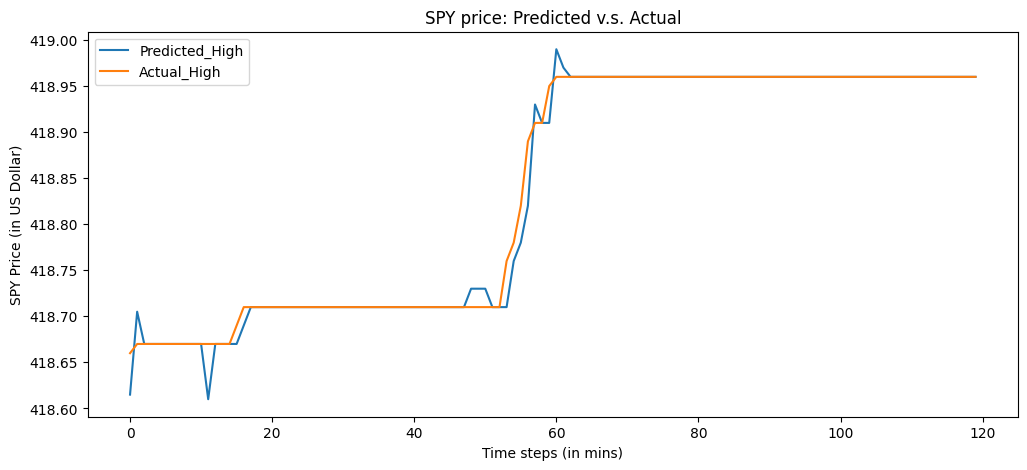

In [310]:
# start_date = 
plt.figure(figsize=(12,5))
high_pred = plt.plot(range(NUM_TEST), predicted_stock_data[:, 1])
high_actual = plt.plot(range(NUM_TEST),np.flipud(data_whole[range(NUM_TEST),1]))
plt.title('SPY price: Predicted v.s. Actual')
plt.legend(('Predicted_High', 'Actual_High'))
plt.xlabel('Time steps (in mins)')
plt.ylabel('SPY Price (in US Dollar)')

plt.show()

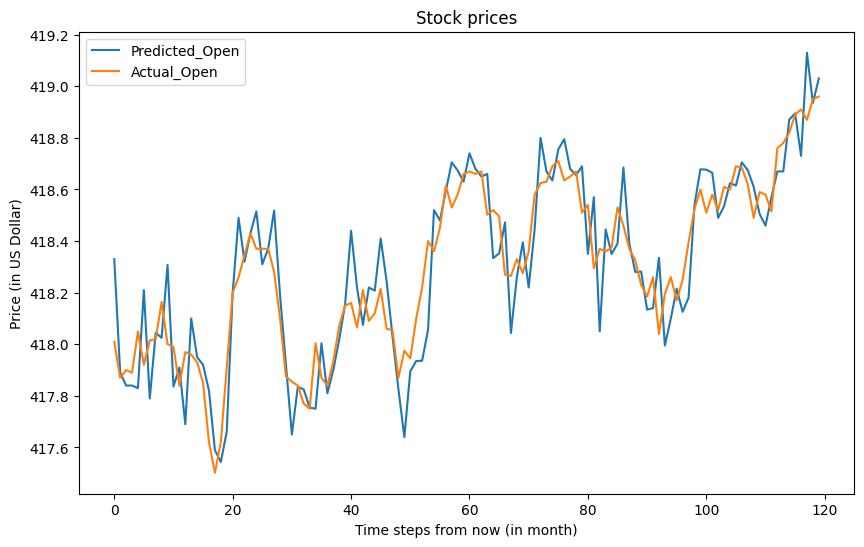

In [311]:
# start_date = 
plt.figure(figsize=(10,6))
high_pred = plt.plot(range(NUM_TEST), predicted_stock_data[:, 0])
high_actual = plt.plot(range(NUM_TEST),np.flipud(data_whole[range(NUM_TEST),0]))
plt.title('Stock prices')
plt.legend(('Predicted_Open', 'Actual_Open'))
plt.xlabel('Time steps from now (in month)')
plt.ylabel('Price (in US Dollar)')

plt.show()

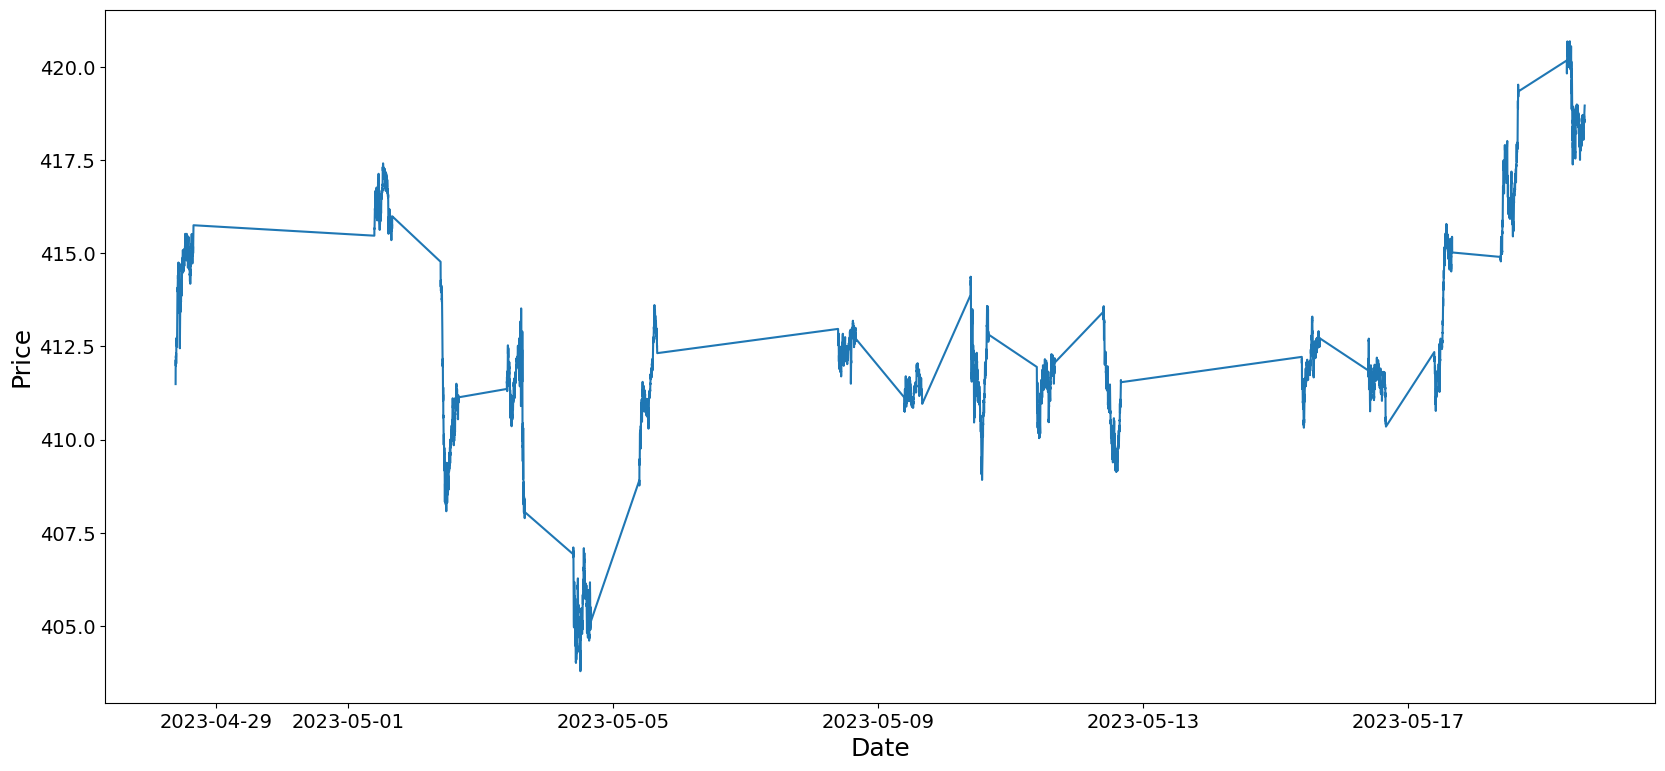

In [258]:
plt.figure(figsize=(20,9))

# plt.plot(df_merged.time, df_merged['open'])
# plt.plot(df_merged.time, df_merged['high'])
# plt.plot(df_merged.time, df_merged['low'])
# plt.plot(df_merged.time, df_merged['close'])
plt.plot(dfhl.time, dfhl['open'])

plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()